In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#Auto reload modules when code is changed
%load_ext autoreload
%autoreload 2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
import os
import torch.nn as nn 
import torch 
import yaml 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from torch.utils.data import Dataset, DataLoader
import random
from laserscan import LaserScan
from collections import OrderedDict
import matplotlib.pyplot as plt


In [2]:
# Code adapted from SalsaNext @ Tiago Cortinhal 
class ClaSeKDataset(Dataset):

    def __init__(self, root,  # directory where data is
                 split,  # train or test
                 df, # pandas dataframe containing filename and label
                 label_dict,  # label dict: (e.g 10: "car")
                 sensor,  # sensor to parse scans from
                 max_points=150000,  # max number of points present in dataset
                 gt=True,
                 transform=False):
        # save deats
        self.root = os.path.join(root, split)
        self.label_dict = label_dict
        self.df = df
        self.sensor = sensor
        self.sensor_img_H = sensor["img_prop"]["height"]
        self.sensor_img_W = sensor["img_prop"]["width"]
        self.sensor_img_means = torch.tensor(sensor["img_means"],
                                             dtype=torch.float)
        self.sensor_img_stds = torch.tensor(sensor["img_stds"],
                                            dtype=torch.float)
        self.sensor_fov_up = sensor["fov_up"]
        self.sensor_fov_down = sensor["fov_down"]
        self.max_points = max_points
        self.gt = gt
        self.transform = transform

        self.nclasses = len(label_dict.keys())

        # make sure directory exists
        if os.path.isdir(self.root):
            print("Sequences folder exists! Using sequences from %s" % self.root)
        else:
            raise ValueError("Sequences folder doesn't exist! Exiting...")

        # make sure labels is a dict
        assert (isinstance(self.label_dict, dict))

    def __getitem__(self, index):
        # get item in tensor shape
        item = self.df.iloc[index]

        scan_file = os.path.join(self.root, item.FNAME)

        if self.gt:
            label = item.LABEL
        else:
            label = 0

        # open a semantic laserscan
        DA = False
        flip_sign = False
        rot = False
        drop_points = False
        if self.transform:
            if random.random() > 0.5:
                if random.random() > 0.5:
                    DA = True
                if random.random() > 0.5:
                    flip_sign = True
                if random.random() > 0.5:
                    rot = True
                drop_points = random.uniform(0, 0.5)

        scanner_class = LaserScan

        scan = scanner_class(project=True,
                                 H=self.sensor_img_H,
                                 W=self.sensor_img_W,
                                 fov_up=self.sensor_fov_up,
                                 fov_down=self.sensor_fov_down,
                                 DA=DA,
                                 rot=rot,
                                 flip_sign=flip_sign,
                                 drop_points=drop_points)


        scan.open_scan(scan_file)
        # make a tensor of the uncompressed data (with the max num points)
        unproj_n_points = scan.points.shape[0]
        if unproj_n_points < self.max_points:
            points_to_copy = unproj_n_points
        else:
            points_to_copy = self.max_points

        unproj_xyz = torch.full((self.max_points, 3), -1.0, dtype=torch.float)
        unproj_xyz[:points_to_copy] = torch.from_numpy(scan.points[: points_to_copy])
        unproj_range = torch.full([self.max_points], -1.0, dtype=torch.float)
        unproj_range[: points_to_copy] = torch.from_numpy(scan.unproj_range[: points_to_copy])
        unproj_remissions = torch.full([self.max_points], -1.0, dtype=torch.float)
        unproj_remissions[: points_to_copy] = torch.from_numpy(scan.remissions[: points_to_copy])

        # get points and labels
        proj_range = torch.from_numpy(scan.proj_range).clone()
        proj_xyz = torch.from_numpy(scan.proj_xyz).clone()
        proj_remission = torch.from_numpy(scan.proj_remission).clone()
        proj_mask = torch.from_numpy(scan.proj_mask)

        proj_x = torch.full([self.max_points], -1, dtype=torch.long)
        proj_x[: points_to_copy] = torch.from_numpy(scan.proj_x[: points_to_copy])
        proj_y = torch.full([self.max_points], -1, dtype=torch.long)
        proj_y[: points_to_copy] = torch.from_numpy(scan.proj_y[: points_to_copy])
        proj = torch.cat([proj_range.unsqueeze(0).clone(),
                          proj_xyz.clone().permute(2, 0, 1),
                          proj_remission.unsqueeze(0).clone()])
        proj = (proj - self.sensor_img_means[:, None, None]
                ) / self.sensor_img_stds[:, None, None]
        proj = proj * proj_mask.float()

        # return
        return proj, label, index

    def __len__(self):
        return self.df.shape[0]

    @staticmethod
    def map(label, mapdict):
        # put label from original values to xentropy
        # or vice-versa, depending on dictionary values
        # make learning map a lookup table
        maxkey = 0
        for key, data in mapdict.items():
            if isinstance(data, list):
                nel = len(data)
            else:
                nel = 1
            if key > maxkey:
                maxkey = key
        # +100 hack making lut bigger just in case there are unknown labels
        if nel > 1:
            lut = np.zeros((maxkey + 100, nel), dtype=np.int32)
        else:
            lut = np.zeros((maxkey + 100), dtype=np.int32)
        for key, data in mapdict.items():
            try:
                lut[key] = data
            except IndexError:
                print("Wrong key ", key)
        # do the mapping
        return lut[label]

In [3]:
# Code Adapted from SalsaNext @ Tiago Cortinhal 
class ResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(ResContextBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=1)
        self.act1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(out_filters, out_filters, (3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        #self.bn1 = nn.BatchNorm2d(out_filters)
        self.bn1 = nn.InstanceNorm2d(out_filters, affine=True)

        self.conv3 = nn.Conv2d(out_filters, out_filters, (3,3),dilation=2, padding=2)
        self.act3 = nn.LeakyReLU()
        self.bn2 = nn.InstanceNorm2d(out_filters, affine=True)


    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)
        resA = self.conv2(shortcut)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)


        output = shortcut + resA2
        return output


class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, dropout_rate, kernel_size=(3, 3), stride=1,
                 pooling=True, drop_out=True):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=stride)
        self.act1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_filters, out_filters, kernel_size=(3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        #self.bn1 = nn.BatchNorm2d(out_filters)
        self.bn1 = nn.InstanceNorm2d(out_filters, affine=True)

        self.conv3 = nn.Conv2d(out_filters, out_filters, kernel_size=(3,3),dilation=2, padding=2)
        self.act3 = nn.LeakyReLU()
        #self.bn2 = nn.BatchNorm2d(out_filters)
        self.bn2 = nn.InstanceNorm2d(out_filters, affine=True)

        self.conv4 = nn.Conv2d(out_filters, out_filters, kernel_size=(2, 2), dilation=2, padding=1)
        self.act4 = nn.LeakyReLU()
        #self.bn3 = nn.BatchNorm2d(out_filters)
        self.bn3 = nn.InstanceNorm2d(out_filters, affine=True)

        self.conv5 = nn.Conv2d(out_filters*3, out_filters, kernel_size=(1, 1))
        self.act5 = nn.LeakyReLU()
        #self.bn4 = nn.BatchNorm2d(out_filters)
        self.bn4 = nn.InstanceNorm2d(out_filters, affine=True)

        if pooling:
            self.dropout = nn.Dropout2d(p=dropout_rate)
            #self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
        else:
            self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = self.act1(shortcut)
        resA = self.conv2(x)
        resA = self.act2(resA)
        resA1 = self.bn1(resA)

        resA = self.conv3(resA1)
        resA = self.act3(resA)
        resA2 = self.bn2(resA)

        resA = self.conv4(resA2)
        resA = self.act4(resA)
        resA3 = self.bn3(resA)

        concat = torch.cat((resA1,resA2,resA3),dim=1)
        resA = self.conv5(concat)
        resA = self.act5(resA)
        resA = self.bn4(resA)


        resA = shortcut + resA

        if self.pooling:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            resB = self.pool(resB)

            return resB, resA
        else:
            if self.drop_out:
                resB = self.dropout(resA)
            else:
                resB = resA
            return resB

class SalsaNext(nn.Module):
    def __init__(self, nclasses):
        super(SalsaNext, self).__init__()
        self.nclasses = nclasses

        self.downCntx = ResContextBlock(5, 32)

        self.downCntx2 = ResContextBlock(32, 32)
        self.downCntx3 = ResContextBlock(32, 32)

        self.resBlock1 = ResBlock(32, 2 * 32, 0.2, pooling=True, drop_out=False)
        self.resBlock2 = ResBlock(2 * 32, 2 * 2 * 32, 0.2, pooling=True)
        self.resBlock3 = ResBlock(2 * 2 * 32, 2 * 4 * 32, 0.2, pooling=True)
        self.resBlock4 = ResBlock(2 * 4 * 32, 2 * 4 * 32, 0.2, pooling=True)       
        self.resBlock5 = ResBlock(2 * 4 * 32, 2 * 4 * 32, 0.2, pooling=False)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.logits = nn.Conv2d(256, nclasses, kernel_size=(1, 1))

    def forward(self, x):
        downCntx = self.downCntx(x)
        downCntx = self.downCntx2(downCntx)
        downCntx = self.downCntx3(downCntx)

        down0c, down0b = self.resBlock1(downCntx)
        down1c, down1b = self.resBlock2(down0c)
        down2c, down2b = self.resBlock3(down1c)
        down3c, down3b = self.resBlock4(down2c)
        down4c = self.resBlock5(down3c)
        
        out = self.pool(down4c)

        logits = self.logits(out)
        
        return logits.squeeze()

In [4]:
#This model is more complex, with more Conv layers
class SimpleModel3(torch.nn.Module):
    def __init__(self,num_channels, num_classes, input_shape=(64,64)):
        super(SimpleModel3,self).__init__()
        layers = []
        num_layers = 5
        for i in range(num_layers):
            layers.append(self._conv_layer_set(num_channels, 64))
            num_channels = 64
        
        layers.append(nn.Flatten())
        layers.append(nn.Linear(num_channels*(input_shape[0]*input_shape[1]//(4**num_layers)), 64))
        layers.append(nn.Dropout(0.25))
        layers.append(nn.BatchNorm1d(64))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.25))
        layers.append(nn.Linear(64, num_classes))
        self.layers = nn.Sequential(*layers)
        self.drop = nn.Dropout(0.25)
        self.batch_norm = nn.BatchNorm1d(64)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('batch_norm',nn.BatchNorm2d(out_c)),
            ('relu',nn.ReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
LABEL_DICT = {0: "car", 1: "bicycle", 2: "motorcycle", 3: "truck", 4: "other_vehicle", 5: "person", 6: "motorcyclist",
              7: "road", 8: "parking", 9: "sidewalk", 10: "other_ground", 11: "building", 12: "fence", 13: "vegetation",
              14: "trunk", 15: "terrain", 16: "pole", 17: "traffic_sign"}
DATA_DIR = '../data/'
DATA_MEAN = np.array([0.43, 0.28, -0.67, 10.80]) # x, y, z, signal
DATA_STD = np.array([1.17, 1.40, 0.05, 0.97]) # x, y, z, signal
N_CLASSES = 18


In [6]:
conf_path = '../data/ds.yaml'
with open(conf_path, 'r') as stream:
    ds_conf = yaml.safe_load(stream)

sensor = ds_conf['dataset']['sensor']
max_points = ds_conf['dataset']['max_points']
train_file = os.path.join(DATA_DIR, 'train.csv')
test_file = os.path.join(DATA_DIR, 'test.csv')
test_df = pd.read_csv(test_file)
df = pd.read_csv(train_file)

In [7]:
train_df, val_df = train_test_split(df, stratify=df.LABEL.values, test_size=0.2, shuffle=True, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [8]:
#Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [9]:
batch_size = 8

train_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                 split='train',  # train or test
                 df=train_df, # pandas dataframe containing filename and label
                 label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                 sensor=sensor,  # sensor to parse scans from
                 max_points=max_points,  # max number of points present in dataset
                 gt=True,
                 transform=True)
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                 split='train',  # train or test
                 df=val_df, # pandas dataframe containing filename and label
                 label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                 sensor=sensor,  # sensor to parse scans from
                 max_points=max_points,  # max number of points present in dataset
                 gt=True,
                 transform=False)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)

test_ds = ClaSeKDataset(root=DATA_DIR,  # directory where data is
                 split='test',  # train or test
                 df=test_df, # pandas dataframe containing filename and label
                 label_dict=LABEL_DICT,  # label dict: (e.g 10: "car")
                 sensor=sensor,  # sensor to parse scans from
                 max_points=max_points,  # max number of points present in dataset
                 gt=False,
                 transform=False)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)

Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/train
Sequences folder exists! Using sequences from ../data/test


In [10]:
#get next item from train_loader
for i, (proj, label, index) in enumerate(train_loader):
    print(proj.shape)
    print(label.shape)
    print(index.shape)
    break

torch.Size([8, 5, 64, 2048])
torch.Size([8])
torch.Size([8])


In [11]:
#model = SimpleModel3(num_channels=5, num_classes=N_CLASSES, input_shape=(64, 2048))

In [12]:
#output = model(proj)

In [20]:
criterion = nn.CrossEntropyLoss().to(device)
# model = PointNet(15000, N_CLASSES).to(device)
#model = SalsaNext(nclasses=N_CLASSES).to(device)
model = SimpleModel3(num_channels=5, num_classes=N_CLASSES, input_shape=(64, 2048)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [21]:
# #load state dict if available
# fileName = '../models/salsanext_2023-10-15_01-15-16.pth'
# if os.path.isfile(fileName):
#     print("Loading model...")
#     model.load_state_dict(torch.load(fileName))

In [22]:
def train_epoch(epoch, model, loader, criterion, optimizer, device):
    model.train()
    loss_list = list()
    pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    for i, (data, proj_labels, _) in enumerate(loader):
        data = data.float().to(device)
        label = proj_labels.long().to(device)
        optimizer.zero_grad()
        logit = model(data)
        loss = criterion(logit, label)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({'Loss': np.mean(loss_list)})
    pbar.close()
    return np.mean(loss_list)

def validate_epoch(epoch, model, loader, criterion, device):
    model.eval()
    loss_list = list()
    gts = list()
    preds = list()
    pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    with torch.no_grad():
        for i, (data, proj_labels,_) in enumerate(loader):
            data = data.float().to(device)
            label = proj_labels.long().to(device)
            logit = model(data)
            pred = torch.argmax(logit, dim=1)
            gts.extend(label.detach().cpu().numpy().tolist())
            preds.extend(pred.detach().cpu().numpy().tolist())
            loss = criterion(logit, label)
            loss_list.append(loss.item())
            pbar.update(1)
            pbar.set_postfix({'Loss': np.mean(loss_list)})
    pbar.close()
    gts = np.array(gts)
    preds = np.array(preds)
    acc = accuracy_score(y_true= gts, y_pred=preds)
    return np.mean(loss_list), acc


In [23]:
# Add the day and time of training to the model name
import datetime
now = datetime.datetime.now()
model_name = f'salsanext_{now.strftime("%Y-%m-%d_%H-%M-%S")}.pth'
model_base_path = '../models/'
model_path = os.path.join(model_base_path, model_name)
submission_path = os.path.join(model_base_path, f'submission_{model_name}.csv')
print(model_path)
print(submission_path)

../models/salsanext_2023-10-15_22-36-43.pth
../models/submission_salsanext_2023-10-15_22-36-43.pth.csv


In [24]:
epoch = 0
total_epoch = 50
train_losses = list()
val_losses = list()
val_accs = list()
best_val_acc = 0
best_val_loss = np.inf


In [25]:
#Keep training
#total_epoch = 10

In [26]:
while epoch < total_epoch:
    train_loss = train_epoch(epoch, model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(epoch, model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving model at epoch: {epoch}, val acc: {val_acc}')

    print('Epoch: %d Current val acc is %.3f while the best val acc is %.3f' %
          (epoch, val_acc, best_val_acc))
    epoch += 1

Epoch 0: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s, Loss=1.75]


Saving model at epoch: 0, val acc: 0.46445497630331756
Epoch: 0 Current val acc is 0.464 while the best val acc is 0.464


Epoch 1: 100%|██████████| 27/27 [00:02<00:00, 13.45it/s, Loss=1.67]


Saving model at epoch: 1, val acc: 0.4834123222748815
Epoch: 1 Current val acc is 0.483 while the best val acc is 0.483


Epoch 2: 100%|██████████| 27/27 [00:02<00:00, 13.44it/s, Loss=1.43]


Saving model at epoch: 2, val acc: 0.5402843601895735
Epoch: 2 Current val acc is 0.540 while the best val acc is 0.540


Epoch 3: 100%|██████████| 27/27 [00:02<00:00, 13.17it/s, Loss=1.48]


Epoch: 3 Current val acc is 0.507 while the best val acc is 0.540


Epoch 4: 100%|██████████| 27/27 [00:02<00:00, 13.44it/s, Loss=1.41]


Saving model at epoch: 4, val acc: 0.5592417061611374
Epoch: 4 Current val acc is 0.559 while the best val acc is 0.559


Epoch 5: 100%|██████████| 27/27 [00:02<00:00, 13.40it/s, Loss=1.39]


Epoch: 5 Current val acc is 0.540 while the best val acc is 0.559


Epoch 6: 100%|██████████| 27/27 [00:02<00:00, 13.20it/s, Loss=1.29]


Epoch: 6 Current val acc is 0.536 while the best val acc is 0.559


Epoch 7: 100%|██████████| 27/27 [00:02<00:00, 13.42it/s, Loss=1.18]


Saving model at epoch: 7, val acc: 0.6208530805687204
Epoch: 7 Current val acc is 0.621 while the best val acc is 0.621


Epoch 8: 100%|██████████| 27/27 [00:02<00:00, 13.22it/s, Loss=1.06]


Saving model at epoch: 8, val acc: 0.6777251184834123
Epoch: 8 Current val acc is 0.678 while the best val acc is 0.678


Epoch 9: 100%|██████████| 27/27 [00:02<00:00, 13.35it/s, Loss=1.11]


Epoch: 9 Current val acc is 0.649 while the best val acc is 0.678


Epoch 10: 100%|██████████| 27/27 [00:02<00:00, 13.27it/s, Loss=1.03]


Epoch: 10 Current val acc is 0.640 while the best val acc is 0.678


Epoch 11: 100%|██████████| 27/27 [00:02<00:00, 13.10it/s, Loss=0.995]


Epoch: 11 Current val acc is 0.649 while the best val acc is 0.678


Epoch 12: 100%|██████████| 27/27 [00:02<00:00, 13.41it/s, Loss=1.1]


Epoch: 12 Current val acc is 0.626 while the best val acc is 0.678


Epoch 13: 100%|██████████| 27/27 [00:02<00:00, 13.50it/s, Loss=0.937]


Saving model at epoch: 13, val acc: 0.6919431279620853
Epoch: 13 Current val acc is 0.692 while the best val acc is 0.692


Epoch 14: 100%|██████████| 27/27 [00:02<00:00, 13.21it/s, Loss=0.934]


Saving model at epoch: 14, val acc: 0.7109004739336493
Epoch: 14 Current val acc is 0.711 while the best val acc is 0.711


Epoch 15: 100%|██████████| 27/27 [00:02<00:00, 13.33it/s, Loss=0.934]


Epoch: 15 Current val acc is 0.678 while the best val acc is 0.711


Epoch 16: 100%|██████████| 27/27 [00:02<00:00, 13.39it/s, Loss=0.991]


Epoch: 16 Current val acc is 0.659 while the best val acc is 0.711


Epoch 17: 100%|██████████| 27/27 [00:02<00:00, 13.48it/s, Loss=0.99]


Epoch: 17 Current val acc is 0.664 while the best val acc is 0.711


Epoch 18: 100%|██████████| 27/27 [00:02<00:00, 13.22it/s, Loss=0.893]


Epoch: 18 Current val acc is 0.697 while the best val acc is 0.711


Epoch 19: 100%|██████████| 27/27 [00:02<00:00, 13.41it/s, Loss=0.922]


Epoch: 19 Current val acc is 0.659 while the best val acc is 0.711


Epoch 20: 100%|██████████| 27/27 [00:02<00:00, 13.37it/s, Loss=0.829]


Epoch: 20 Current val acc is 0.701 while the best val acc is 0.711


Epoch 21: 100%|██████████| 27/27 [00:02<00:00, 13.50it/s, Loss=0.912]


Epoch: 21 Current val acc is 0.706 while the best val acc is 0.711


Epoch 22: 100%|██████████| 27/27 [00:02<00:00, 13.32it/s, Loss=0.89]


Epoch: 22 Current val acc is 0.711 while the best val acc is 0.711


Epoch 23: 100%|██████████| 27/27 [00:02<00:00, 13.37it/s, Loss=0.927]


Epoch: 23 Current val acc is 0.668 while the best val acc is 0.711


Epoch 24: 100%|██████████| 27/27 [00:02<00:00, 13.39it/s, Loss=0.841]


Epoch: 24 Current val acc is 0.673 while the best val acc is 0.711


Epoch 25: 100%|██████████| 27/27 [00:02<00:00, 13.43it/s, Loss=0.902]


Epoch: 25 Current val acc is 0.673 while the best val acc is 0.711


Epoch 26: 100%|██████████| 27/27 [00:02<00:00, 13.18it/s, Loss=0.871]


Epoch: 26 Current val acc is 0.706 while the best val acc is 0.711


Epoch 27: 100%|██████████| 27/27 [00:02<00:00, 13.31it/s, Loss=0.875]


Epoch: 27 Current val acc is 0.673 while the best val acc is 0.711


Epoch 28: 100%|██████████| 27/27 [00:02<00:00, 12.82it/s, Loss=0.906]


Epoch: 28 Current val acc is 0.706 while the best val acc is 0.711


Epoch 29: 100%|██████████| 27/27 [00:01<00:00, 13.61it/s, Loss=0.902]


Epoch: 29 Current val acc is 0.692 while the best val acc is 0.711


Epoch 30: 100%|██████████| 27/27 [00:01<00:00, 13.71it/s, Loss=0.982]


Epoch: 30 Current val acc is 0.659 while the best val acc is 0.711


Epoch 31: 100%|██████████| 27/27 [00:01<00:00, 13.73it/s, Loss=0.887]


Epoch: 31 Current val acc is 0.692 while the best val acc is 0.711


Epoch 32: 100%|██████████| 27/27 [00:01<00:00, 13.63it/s, Loss=0.883]


Epoch: 32 Current val acc is 0.659 while the best val acc is 0.711


Epoch 33: 100%|██████████| 27/27 [00:01<00:00, 13.66it/s, Loss=0.832]


Epoch: 33 Current val acc is 0.692 while the best val acc is 0.711


Epoch 34: 100%|██████████| 27/27 [00:01<00:00, 13.69it/s, Loss=0.859]


Epoch: 34 Current val acc is 0.678 while the best val acc is 0.711


Epoch 35: 100%|██████████| 27/27 [00:01<00:00, 13.76it/s, Loss=0.863]


Epoch: 35 Current val acc is 0.673 while the best val acc is 0.711


Epoch 36: 100%|██████████| 27/27 [00:01<00:00, 13.72it/s, Loss=0.821]


Epoch: 36 Current val acc is 0.711 while the best val acc is 0.711


Epoch 37: 100%|██████████| 27/27 [00:01<00:00, 13.68it/s, Loss=0.793]


Saving model at epoch: 37, val acc: 0.7345971563981043
Epoch: 37 Current val acc is 0.735 while the best val acc is 0.735


Epoch 38: 100%|██████████| 27/27 [00:01<00:00, 13.52it/s, Loss=0.841]


Epoch: 38 Current val acc is 0.668 while the best val acc is 0.735


Epoch 39: 100%|██████████| 27/27 [00:01<00:00, 13.60it/s, Loss=0.825]


Epoch: 39 Current val acc is 0.716 while the best val acc is 0.735


Epoch 40: 100%|██████████| 27/27 [00:01<00:00, 13.75it/s, Loss=0.8]


Epoch: 40 Current val acc is 0.682 while the best val acc is 0.735


Epoch 41: 100%|██████████| 27/27 [00:01<00:00, 13.69it/s, Loss=0.837]


Epoch: 41 Current val acc is 0.697 while the best val acc is 0.735


Epoch 42: 100%|██████████| 27/27 [00:01<00:00, 13.88it/s, Loss=0.807]


Epoch: 42 Current val acc is 0.711 while the best val acc is 0.735


Epoch 43: 100%|██████████| 27/27 [00:02<00:00, 13.39it/s, Loss=0.739]


Saving model at epoch: 43, val acc: 0.7535545023696683
Epoch: 43 Current val acc is 0.754 while the best val acc is 0.754


Epoch 44: 100%|██████████| 27/27 [00:01<00:00, 13.90it/s, Loss=0.819]


Epoch: 44 Current val acc is 0.720 while the best val acc is 0.754


Epoch 45: 100%|██████████| 27/27 [00:01<00:00, 13.78it/s, Loss=0.852]


Epoch: 45 Current val acc is 0.711 while the best val acc is 0.754


Epoch 46: 100%|██████████| 27/27 [00:01<00:00, 13.63it/s, Loss=0.876]


Epoch: 46 Current val acc is 0.697 while the best val acc is 0.754


Epoch 47: 100%|██████████| 27/27 [00:01<00:00, 13.93it/s, Loss=0.815]


Epoch: 47 Current val acc is 0.716 while the best val acc is 0.754


Epoch 48: 100%|██████████| 27/27 [00:01<00:00, 13.74it/s, Loss=0.835]


Epoch: 48 Current val acc is 0.692 while the best val acc is 0.754


Epoch 49: 100%|██████████| 27/27 [00:01<00:00, 13.74it/s, Loss=0.822]

Epoch: 49 Current val acc is 0.701 while the best val acc is 0.754


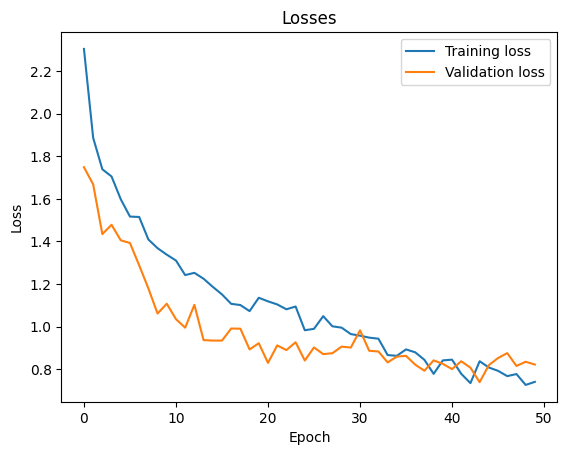

In [27]:
#plot the losses as a function of epochs
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

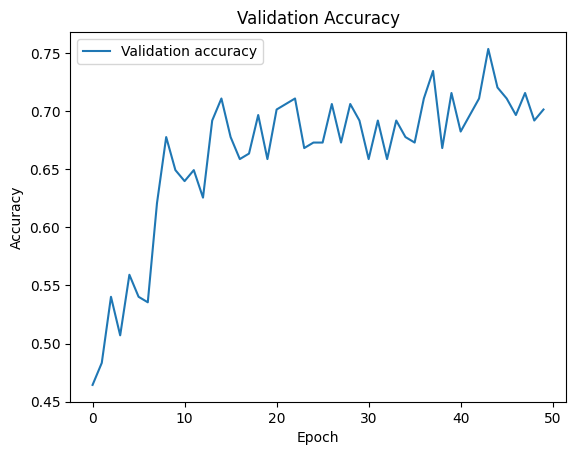

In [28]:
plt.plot(val_accs, label="Validation accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [29]:
def generate_submission_file(model, loader, device):
    model.eval()
    indices_list = list()
    preds = list()
    pbar = tqdm(total=len(loader), desc=f'Epoch {epoch}')
    with torch.no_grad():
        for i, (data, proj_labels, indices) in enumerate(
                loader):
            data = data.float().to(device)
            label = proj_labels.long().to(device)
            logit = model(data)
            pred = torch.argmax(logit, dim=1)
            indices_list.extend(indices.detach().cpu().numpy().tolist())
            preds.extend(pred.detach().cpu().numpy().tolist())
            pbar.update(1)
    pbar.close()
    sample = test_df.iloc[indices_list]
    sample['LABEL'] = preds
    return sample 

In [31]:
model = SimpleModel3(num_channels=5, num_classes=N_CLASSES, input_shape=(64, 2048)).to(device)
model.load_state_dict(torch.load(model_path))
sample = generate_submission_file(model, test_loader, device)

Epoch 50: 100%|██████████| 150/150 [00:12<00:00, 11.79it/s]


In [32]:
sample.reset_index(drop=True, inplace=True)

In [33]:
sample

,FNAME,LABEL
0,06_122845.bin,15
1,08_925129.bin,16
2,08_976795.bin,12
3,06_317230.bin,12
4,08_386622.bin,0
...,...,...
1191,08_211179.bin,0
1192,08_672278.bin,11
1193,08_399783.bin,13
1194,05_205440.bin,15


In [34]:

sample.to_csv(submission_path, index=None)